# Modül 4 :: Veri Seti Üzerinde Çalışmalar

<a target="_blank" href="https://colab.research.google.com/github/Frightera/ML-Kursu-Youtube/blob/main/Notebooklar/ML_Modul04_OnIsleme_ve_FE_SigortaVerisi.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/> </a>

## Veri Seti Açıklaması

Bu veri bir sigorta şirketinin geçmiş verilerini içerir ve bir poliçe sahibinin sigorta talebinde bulunup bulunmayacağını (claim_status) tahmin etmeyi amaçlar.

Veri poliçe sahibinin demografik bilgilerinden aracın teknik özelliklerine kadar çok çeşitli bilgiler içerir. Sigortacılıkta bu tür tahminler, risk analizi, fiyatlandırma ve sahtekarlık tespiti için hayati önem taşır.

### Temel Amaç
Bir poliçe için talep oluşturulma olasılığını doğru bir şekilde tahmin edebilen sağlam bir makine öğrenmesi modeli geliştirmek.


In [16]:
# !pip install dtale

In [ ]:
import re
from pathlib import Path

import dtale
import dtale.app as dtale_app
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu, pointbiserialr
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_theme(context="notebook", style="whitegrid")

## 1) Veri Yükleme

In [18]:
DATA_PATH = Path("Insurance claims data.csv")
df = pd.read_csv(DATA_PATH)
TARGET = "claim_status"

assert TARGET in df.columns, "claim_status sütunu yok."

df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")
print("Şekil:", df.shape)
df.head(3)

Şekil: (58592, 41)


,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0


In [19]:
dtale_app.USE_COLAB = True
dtale.show(df)

https://40000-m-s-jnyq9v2on0my-d.us-east1-1.prod.colab.dev/dtale/main/2

## 2) Şema Özeti

Bir veri setini anlamanın ilk adımı, onun şemasına, yani sütunlarına, veri tiplerine, eksik değer oranlarına ve benzersiz değer sayılarına bakmaktır.

Tablo en çok ilgilenmemiz gereken sütunları (en çok eksik değere sahip olanlar) en üste getirecek şekilde sıralanmıştır.

* **Eksik Değerler**: Bu özel veri setinde hiç eksik değer bulunmuyor (missing_% sütununun tamamı 0.0). Bu durum veri temizleme işimizi oldukça kolaylaştıran ideal bir durumdur.

Benzersiz Değerler `(n_unique)`: Bu sütun bize bir özelliğin kendisi hakkında ipuçları verir.

* **n_unique** = 2: Bunlar ikili (binary) özelliklerdir (claim_status, is_esc, vb.).
    * Genellikle `"Evet/Hayır"` veya `"Var/Yok"` durumlarını temsil ederler.

* **Az n_unique** `(örn: airbags, fuel_type)`: Bunlar az sayıda kategoriye sahip kategorik özelliklerdir.

* **Çok n_unique** `(örn: policy_id)`: Bu her satır için benzersiz bir tanımlayıcıdır. Genellikle model eğitiminde bir özellik olarak kullanılmaz ancak verileri birleştirmek veya takip etmek için önemlidir.

 * `subscription_length` ve `customer_age` gibi sütunlar ise çok sayıda farklı değere sahip sayısal özelliklerdir.

In [20]:
schema_rows = []
for c in df.columns:
    s = df[c]
    schema_rows.append(
        {
            "column": c,
            "dtype": str(s.dtype),
            "missing_%": s.isna().mean() * 100,
            "n_unique": s.nunique(dropna=True),
        }
    )
schema_df = pd.DataFrame(schema_rows).sort_values(
    ["missing_%", "n_unique", "column"], ascending=[False, True, True]
)
schema_df

,column,dtype,missing_%,n_unique
40,claim_status,int64,0.0,2
20,cylinder,int64,0.0,2
14,is_adjustable_steering,object,0.0,2
31,is_brake_assist,object,0.0,2
33,is_central_locking,object,0.0,2
36,is_day_night_rear_view_mirror,object,0.0,2
35,is_driver_seat_height_adjustable,object,0.0,2
37,is_ecw,object,0.0,2
13,is_esc,object,0.0,2
27,is_front_fog_lights,object,0.0,2


## 3) Özellik Mühendisliği (String → Sayısal)
Bazen ham veriler, bir modelin doğrudan anlayabileceği en iyi formatta değildir. Bizim görevimiz, bu veriyi modele "tercüme etmektir".

#### **Problem: Metin İçine Gizlenmiş Sayılar**

Sigorta veri setimizde `max_power` ve `max_torque` adında iki sütunumuz var. Bunlar bir aracın motor gücü ve torku gibi çok önemli bilgiler içeriyor. Ancak, bu sütunların veri tipi `object` (yani metin/string), çünkü içlerindeki değerler şuna benziyor: `"60 bhp @ 5500 rpm"` veya `"90 Nm @ 3500 rpm"`.

*   **Sorun:** Makine öğrenmesi algoritmaları, `"60 bhp @ 5500 rpm"` gibi bir metinden matematiksel bir anlam çıkaramaz. Bu değerli bilgiyi kullanabilmek için onu saf sayısal formata dönüştürmemiz gerekir.

#### **Sonuç: Zenginleştirilmiş Veri Seti**

Bu işlemlerin sonunda, veri setimiz artık sadece temizlenmiş değil, aynı zamanda daha bilgilendirici hale gelmiştir. Orijinal metin sütunlarını daha sonra model eğitiminden çıkarabilir ve onların yerine oluşturduğumuz bu yeni, saf sayısal ve anlamlı özellikleri kullanabiliriz. Böylece modelimizin veri içindeki desenleri daha iyi öğrenmesini sağlayabiliriz.

#### **Çözüm: Regular Expressions (Regex) ile Metni Ayrıştırmak**

Bu tür yapılandırılmış metinlerden belirli parçaları ayıklamak için en güçlü araçlardan biri **Regular Expressions (Regex)**'dir. Metin içinde belirli kalıpları (patterns) aramamızı ve bulduklarımızı çıkarmamızı sağlayan özel bir komut dizisidir.

*   **1. Patternleri Oluşturma (`re.compile`):**
    *   Her bir `re.compile` satırı arayacağımız metin kalıbını tanımlar. Parantez `()` içindeki kısım, `bana bu kalıbın bu kısmını ayıklayıp ver` anlamına gelir.
    
    *   Örneğin `bhp_pat`, bir veya daha fazla rakamdan (`[0-9]+`) oluşan, isteğe bağlı olarak ondalık nokta içerebilen (`\.?`) ve sonunda "bhp" ile biten bir kalıbı arar. `re.I` ise büyük/küçük harf duyarsızlığı sağlar.

*   **2. Gerekeni Alma (`.str.extract`):**
    *   Pandas'ın `.str.extract()` metodu, tanımladığımız bu Regex kalıplarını bir sütundaki her bir satıra uygular.

    *   Kalıp eşleşirse parantez içindeki sayısal kısmı ayıklar. Eşleşmezse `NaN` döndürür.
    
    *   Son olarak `.astype(float)` ile ayıklanan metin halindeki rakamları, matematiksel işlemlerde kullanabileceğimiz gerçek sayılara (float) dönüştürürüz.
    
    *   **Sonuç:** Tek bir `max_power` sütunundan, modelin anlayabileceği `power_bhp` ve `power_rpm` adında iki yeni sayısal sütun elde ettik. Aynı işlemi `max_torque` için de yaptık.

*   **3. Yeni Bir Etkileşim (`bhp_per_nm`):**
        
    *   `power_bhp`'yi `torque_nm`'ye bölerek `bhp_per_nm` adında yeni bir özellik oluşturduk. Bu yeni özellik motorun karakteristiği hakkında bir fikir verebilir (örneğin, yüksek devirde güç üreten bir motor mu, yoksa düşük devirde yüksek tork üreten bir motor mu?). Bazen bu tür **etkileşim özellikleri**, orijinal özelliklerden çok daha fazla `predictive power` sahip olabilir.

**Not:** Predictive Power, bir ML modelinde bir özelliğin hedef değişkeni ne kadar iyi tahmin edebildiğini ifade eden bir terimdir.

In [21]:
# Adım 1: Ayıklamak istediğimiz kalıpları (pattern) tanımlıyoruz.

# bhp_pat: Bir sayı, ardından "bhp" kelimesini arar.
bhp_pat = re.compile(r"([0-9]+\.?[0-9]*)\s*bhp", re.I)

# rpm_pat: "@" işareti, ardından bir sayı ve "rpm" kelimesini arar.
rpm_pat = re.compile(r"@\s*([0-9]+)\s*rpm", re.I)

# nm_pat: Bir sayı, ardından "Nm" kelimesini arar.
nm_pat = re.compile(r"([0-9]+\.?[0-9]*)\s*Nm", re.I)


# Adım 2: Bu kalıpları kullanarak metin sütunlarından yeni sayısal sütunlar oluşturuyoruz.
# max_power sütununu ayrıştıralım
df["power_bhp"] = df["max_power"].astype(str).str.extract(bhp_pat).astype(float)
df["power_rpm"] = df["max_power"].astype(str).str.extract(rpm_pat).astype(float)

# max_torque sütununu ayrıştıralım
df["torque_nm"] = df["max_torque"].astype(str).str.extract(nm_pat).astype(float)
df["torque_rpm"] = df["max_torque"].astype(str).str.extract(rpm_pat).astype(float)

# Adım 3: Yeni özelliklerden daha da yeni bir özellik türetelim.
df["bhp_per_nm"] = df["power_bhp"] / df["torque_nm"]

pd.DataFrame(
    {"column": df.columns, "dtype": [str(df[c].dtype) for c in df.columns]}
).head(30)

,column,dtype
0,policy_id,object
1,subscription_length,float64
2,vehicle_age,float64
3,customer_age,int64
4,region_code,object
5,region_density,int64
6,segment,object
7,model,object
8,fuel_type,object
9,max_torque,object


## 4) Tek Değişkenli Dağılımlar

Harika bir analiz adımı! Veri setini temizleyip yeni özellikler türettikten sonra, bu özelliklerin "karakterini" anlamak için onları görselleştirmek en kritik adımlardan biridir. Bu süreç, **Keşifsel Veri Analizi (Exploratory Data Analysis - EDA)**'nin kalbidir ve modelimizin veriden ne öğrenebileceğine dair bize paha biçilmez ipuçları verir.

Aşağıda, oluşturduğunuz bu zengin görsel setin bir analizini ve her bir grafikten ne gibi dersler çıkardığımızı bulabilirsiniz.

---

### **Veri Setinin Derinlemesine Görsel Analizi**

Bu aşamada, sayısal ve kategorik özelliklerimizin dağılımlarını, yoğunluklarını ve frekanslarını inceleyerek veri setimizin iç yapısını keşfedeceğiz. Bu, özellik dönüşümü, ölçeklendirme ve model seçimi gibi sonraki adımlar için bize yol gösterecektir.

#### **Sayısal Özelliklerin Dağılımları (Histograms)**

Bu grafikler, bir özelliğin hangi değer aralıklarında ne kadar yoğunlaştığını gösterir.

*   **`subscription_length` (Abonelik Süresi):**
    *   **Gözlem:** Bu dağılım **çok modlu (multi-modal)**, yani birden fazla tepe noktası var. Özellikle 1 yıl civarında ve 10-12 yıl civarında iki büyük yığılma görülüyor.
    *   **Yorum:** Müşteri tabanının homojen olmadığını gösterir. Muhtemelen iki ana müşteri segmenti var: yeni veya kısa süreli aboneler ve çok sadık, uzun süreli aboneler. `claim_status`'u tahmin etmede çok önemli bir özellik olabilir.

*   **`vehicle_age` (Araç Yaşı):**
    *   **Gözlem:** Güçlü bir şekilde **sağa çarpık (right-skewed)** bir dağılım. Verilerin ezici çoğunluğu 0-3 yaş aralığındaki yeni araçlarda toplanmış ve yaş arttıkça araç sayısı hızla azalıyor.
    *   **Yorum:** Bu beklenen bir durumdur. Sigortalanan araçların çoğu yenidir. Bu tür bir çarpıklık, bazı modellerin performansını olumsuz etkileyebilir. Modelleme aşamasında bu özelliğe **logaritmik dönüşüm** (`log(1 + x)`) uygulamak, dağılımı daha simetrik hale getirerek modele yardımcı olabilir.

*   **`customer_age` (Müşteri Yaşı):**
    *   **Gözlem:** Normal dağılıma oldukça yakın, ancak hafifçe **sola çarpık (left-skewed)** bir yapı var. Tepe noktası 40-45 yaş aralığında.
    *   **Yorum:** Müşteri kitlesinin çoğunlukla orta yaşlı olduğunu anlıyoruz. Çarpıklık çok belirgin olmadığı için bu özellik doğrudan kullanılabilir.

*   **`region_density` (Bölge Yoğunluğu):**
    *   **Gözlem:** Yine **çok modlu (multi-modal)** bir dağılım. Veriler, belirli yoğunluk seviyelerinde (örn: 10.000, 35.000 civarı) kümelenmiş.
    *   **Yorum:** Müşterilerin farklı tipte yerleşim yerlerinden (kırsal, banliyö, şehir merkezi gibi) geldiğini ve bu yerleşim yerlerinin belirli nüfus yoğunluklarına sahip olduğunu gösterir. Model, farklı yoğunluktaki bölgelerde kaza riskinin farklı olduğunu öğrenebilir.

*   **`airbags`, `displacement`, `cylinder`:**
    *   **Gözlem:** Bu grafikler sürekli bir dağılım gibi görünse de aslında **ayrık (discrete)** sayısal değerleri temsil ediyorlar. Örneğin, bir aracın 2 veya 6 hava yastığı olabilir, ama 2.5 değil. Silindir sayısı 3 veya 4'tür.
    *   **Yorum:** Bu özellikler, sayısal olmalarına rağmen kategorik gibi davranırlar. Modelin bunları doğru yorumlaması için ya olduğu gibi bırakılabilirler ya da buradan kategorik özellikler oluşturulabilir. Mesela hiç hava yastığı olmayan arabanın güvensiz olarak etiketlenmesi gibi.

#### **Kategorik Özelliklerin Dağılımları (Count Plots)**

Bu grafikler her bir kategorinin veri setimizde kaç kez tekrar ettiğini gösterir.

*   **`region_code`, `segment`, `model`:**
    *   **Gözlem:** Bu özelliklerin tümü **dengesiz (imbalanced)** dağılımlara sahip. Yani bazı kategoriler (örn: bölge `C8`, model `M1`) diğerlerinden çok daha sık görülüyor.
    *   **Yorum:** Model sık görülen kategoriler hakkında çok şey öğrenecek ama nadir kategorilerde genelleme yapmakta zorlanabilir. Çok nadir kategorileri (örneğin 10'dan az görünenler) modelleme öncesi "Diğer" (Other) adında tek bir kategoride birleştirmek iyi bir strateji olabilir.

*   **`fuel_type` (Yakıt Tipi):**
    *   **Gözlem:** Diğerlerinin aksine bu özellik oldukça **dengeli (balanced)**. Dizel, CNG ve Benzinli araçların sayıları birbirine oldukça yakın.
    *   **Yorum:** Modelin her yakıt tipinin etkisini adil bir şekilde öğrenebilmesi için yeterli veriye sahip olduğu anlamına gelir. Bu ideal bir durumdur.

*   **`max_torque`, `max_power`, `engine_type` (Orijinal Metin Sütunları):**
    *   **Gözlem:** Bu grafiklerde çok sayıda benzersiz kategori var ve bu da onları doğrudan kullanmayı zorlaştırıyor.
    *   **Yorum:** Bu görseller, bir önceki adımda yaptığımız **ayrımın** neden bu kadar önemli olduğunu gösteriyor. `"113.45bhp@4000rpm"` gibi bir metni doğrudan modele vermek yerine, içinden `113.45` ve `4000` gibi sayıları ayıklamak, bu değerli bilgiyi model için kullanılabilir hale getirmiştir.

#### **Genel Çıkarımlar ve Sonraki Adımlar**

Bu kapsamlı görsel analizden öğrendiklerimiz, modelimizi kurmadan önceki son hazırlık adımı olan **Ön İşleme (Preprocessing)** için yol haritamızı çizer:

1.  **Sayısal Özellikler:** `vehicle_age` gibi sağa çarpık özelliklere **logaritmik dönüşüm** uygulanabilir. Tüm sayısal özelliklerin, farklı ölçeklerde (yaş 35-75 iken, yoğunluk 0-75000) olmasından dolayı bir **ölçekleyiciye (Scaler)** (örn: `StandardScaler` veya `MinMaxScaler`) sokulması gerekecektir.

2.  **Kategorik Özellikler:** `model` veya `region_code` gibi çok sayıda kategoriye sahip özelliklerdeki nadir kategoriler birleştirilebilir. Ardından, tüm kategorik özelliklerin makine tarafından anlaşılabilir sayılara dönüştürülmesi için bir **encoder** (örn: `OneHotEncoder`) kullanılması gerekecektir.

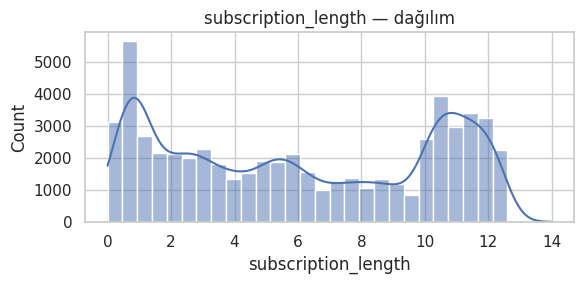

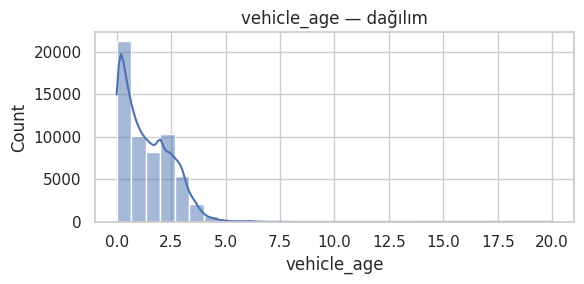

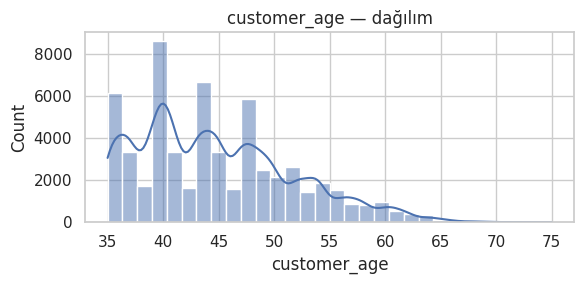

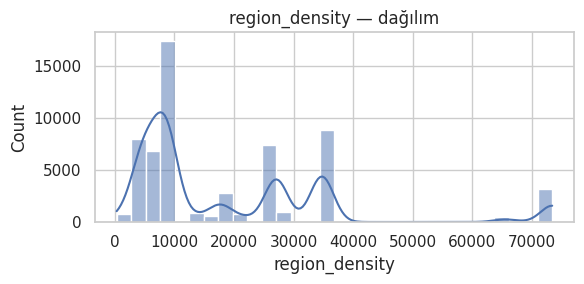

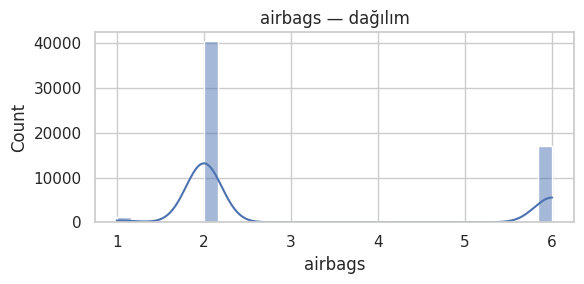

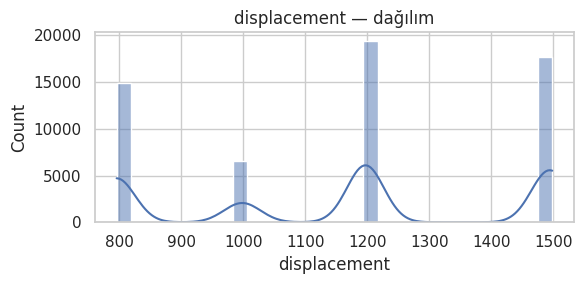

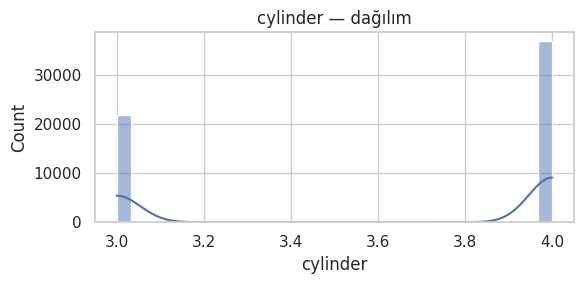

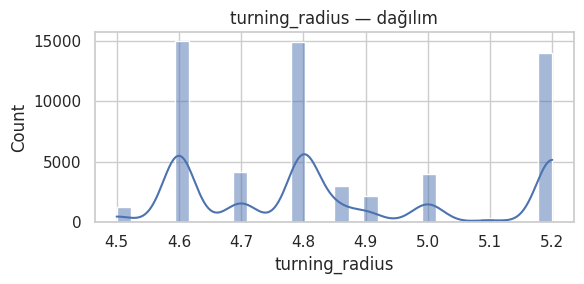

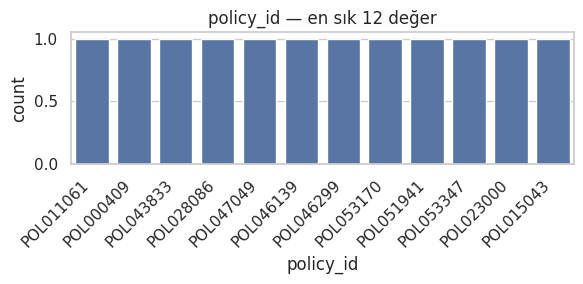

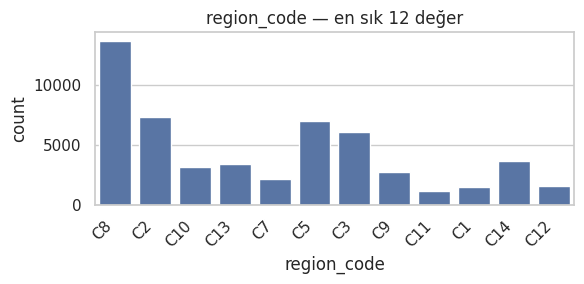

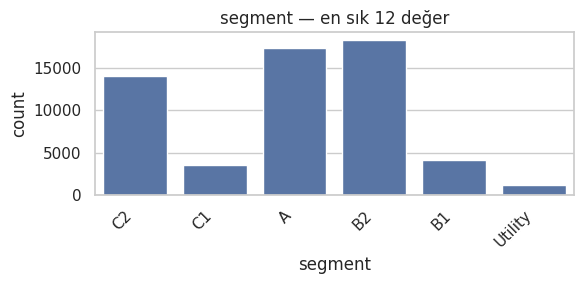

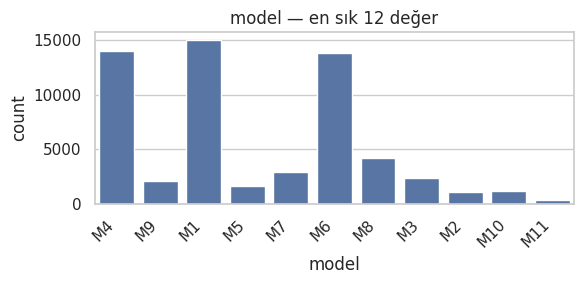

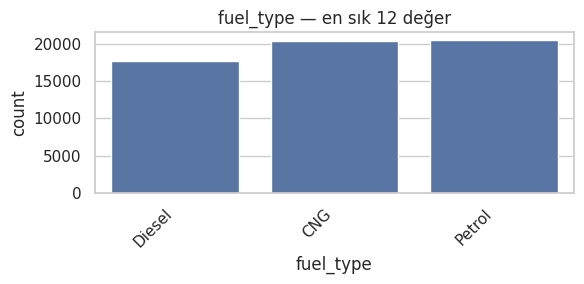

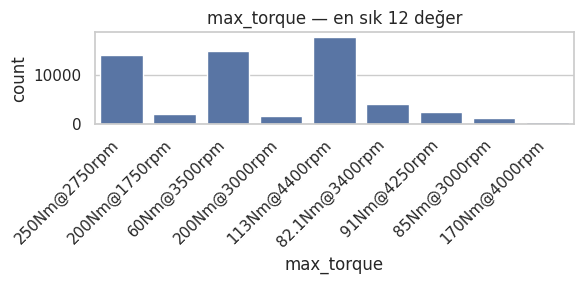

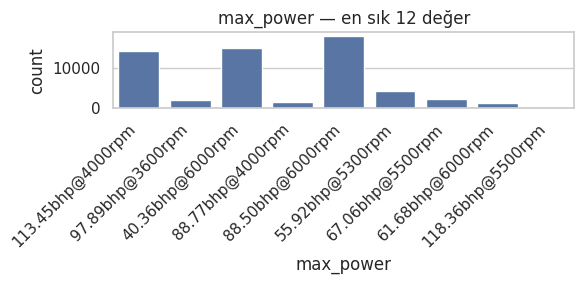

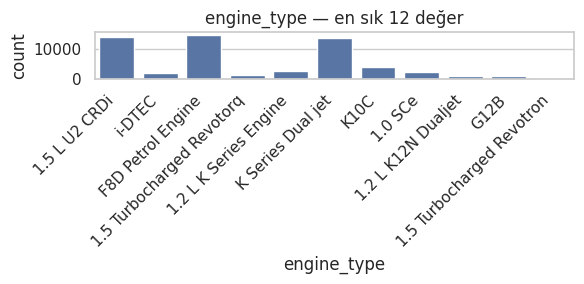

In [22]:
num_cols = [
    c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != TARGET
]
cat_cols = [c for c in df.columns if c not in num_cols and c != TARGET]

for col in num_cols[:8]:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"{col} — dağılım")
    plt.tight_layout()
    plt.show()

for col in cat_cols[:8]:
    top = df[col].value_counts().head(12).index
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df[df[col].isin(top)], x=col)
    plt.title(f"{col} — en sık 12 değer")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

## 5) Hedef Dağılımı ve Dengesizlik
Şimdiye kadar modelimize girdi olarak vereceğimiz özellikleri inceledik. Şimdi ise modelimizin çıktısı olacak olan `claim_status` sütununu, yani "Bir talep oldu mu (1) olmadı mı (0)?" sorusunun cevabını inceleyelim.

#### **Gözlem: Ezici Bir Dengesizlik**

`Genel claim oranı: 0.0640` çıktısı bu durumu rakamlarla ifade ediyor. Veri setimizdeki poliçelerin **sadece %6.4'ü** bir taleple sonuçlanmış. Geriye kalan %93.6'sı ise talepsizdir.

Bu duruma **Sınıf Dengesizliği (Class Imbalance)** denir ve sınıflandırma problemlerinde karşılaşılan en yaygın ve en önemli zorluklardan biridir.

#### **Bu Neden Çok Büyük Bir Sorun? (Doğruluk Paradoksu)**

Bu dengesizlik modelimizin performansı ve değerlendirilmesi üzerinde derin etkilere sahiptir:

**Modelin Tembelliğe Eğilimi:** Çoğu ML modeli (sınıflandırma için tab2) toplam doğruluğu (accuracy) en üst düzeye çıkarmak için optimize edilir. Model veri setinin %93.6'sının `0` olduğunu fark ederse, en kolay yolu seçebilir:

    * "Ne olursa olsun her zaman 0 (talep yok) tahmin et."

**Doğruluk Paradoksu (Accuracy Paradox):** Yukarıdaki "tembel" model hiçbir şey öğrenmese bile **%93.6 oranında doğru** olacaktır!

    * Kağıt üzerinde harika görünen bu doğruluk oranı, pratikte **tamamen işe yaramazdır** çünkü asıl ilgilendiğimiz ve yakalamak istediğimiz `1` sınıfını (talep olanları) tek bir kez bile doğru tahmin edemez.

**Yanlış Değerlendirme Riski:** Eğer modelimizi sadece doğruluk (accuracy) metriği ile değerlendirirsek bu dengesizlik bizi TAMAMEN yanıltabilir.

#### Stratejimizi Belirleyelim?

Bu tespiti projenin başında yapmak hayati önem taşır. Çünkü modelleme stratejimizi doğrudan etkiler:

*   **Doğru Metrikleri Seçmek:** "Accuracy" yerine, bu tür dengesiz veri setleri için daha anlamlı olan:
 * Precision
 * Recall
 * F1-Score
 * **AUC-ROC**

gibi değerlendirme metriklerine odaklanmamız gerekecek. Bu metrikler, modelin azınlık sınıfını ne kadar iyi yakaladığını daha net bir şekilde gösterir.

*   **Dengesizlikle Başa Çıkma Teknikleri:** Modelleme aşamasında bu sorunu çözmek için özel teknikler kullanmamız gerekecek. Bunlardan bazıları:
    *   **Sınıf Ağırlıkları (`class_weight`):** Modelin eğitim sırasında azınlık sınıfından (`1`) yaptığı hatalara daha fazla "ceza" vermesini sağlamak.
    *   **Farklı Loss Fonksiyonu Kullanmak**: İleri seviye modellerde bu durumla daha iyi baş edebilecek loss fonksiyonları seçebiliriz.
    *   ~~**Yeniden Örnekleme (Resampling):** Azınlık sınıfını yapay olarak çoğaltmak (**Oversampling**, örn: SMOTE) veya çoğunluk sınıfını rastgele azaltmak (**Undersampling**).~~ **YOK KULLANMAYIN.** :)

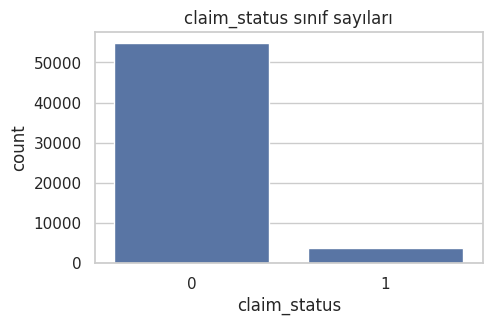

Genel claim oranı: 0.0640


In [23]:
plt.figure(figsize=(5, 3))
sns.countplot(x=TARGET, data=df)
plt.title("claim_status sınıf sayıları")
plt.show()

pos_rate = df[TARGET].mean()
print(f"Genel claim oranı: {pos_rate:.4f}")

## 6) Kategorik × Hedef — Claim Oranı ve Ki-kare Testi

### **İki Değişkenli Analiz: Sinyali Gürültüden Ayırmak**

Bu bölümde, hangi özelliklerin `talep` oranını anlamlı bir şekilde etkilediğini bulmaya çalışacağız. Bir özelliğin farklı kategorileri arasında talep oranı değişiyorsa, o özellik muhtemelen modelimiz için **tahmin gücü yüksek**, yani değerli bir sinyal taşıyordur. Eğer oranlar hemen hemen aynıysa, o özelliğin muhtemelen modele bir faydası olmayacaktır.

#### **Görsel Analiz: Kategorilere Göre Talep Oranları**

Aşağıdaki grafikler, her bir kategorik özelliğin farklı değerleri için ortalama talep oranını (`mean(claim_status)`) göstermektedir. Dikey eksen o kategorideki poliçelerin yüzde kaçının talebe dönüştüğünü ifade eder.

*   **Sinyal Taşıyan Görünen Özellikler:**
    *   **`is_adjustable_steering` & `is_parking_sensors`:** Bu özelliklerde "Yes" ve "No" kategorileri arasında gözle görülür bir fark var. Örneğin, park sensörü olmayan (`No`) araçların talep oranı, olanlara (`Yes`) göre daha düşük görünüyor. Bunlar modelin öğrenebileceği bir desen olabilir.
    *   **`max_torque` & `max_power`:** Bu grafiklerd tork ve güç değerleri değiştikçe talep oranında bir düşüş trendi gözlemleniyor. Bu motor özelliklerinin riskle bir ilişkisi olabileceğini düşündürüyor.
    *   **`segment`:** Farklı araç segmentleri (`B2`, `C2`, `A` vb.) arasında talep oranlarında küçük de olsa farklılıklar mevcut.

*   **Sinyal Taşımayan Görünen Özellikler:**
    *   **`is_esc` & `is_tpms`:** Bu özelliklerde "Yes" ve "No" çubuklarının yükseklikleri neredeyse tamamen aynı. Bu özellikler muhtemelen model için gürültüden ibarettir.
    *   **`fuel_type`:** Benzinli, Dizel ve CNG'li araçların talep oranları birbirine çok yakın.

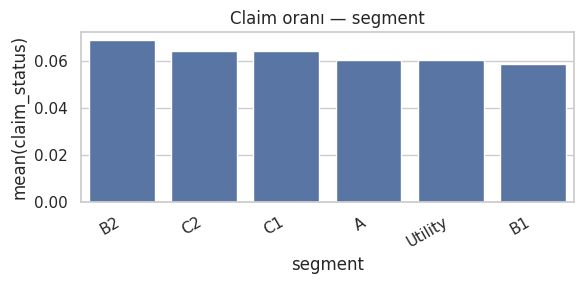

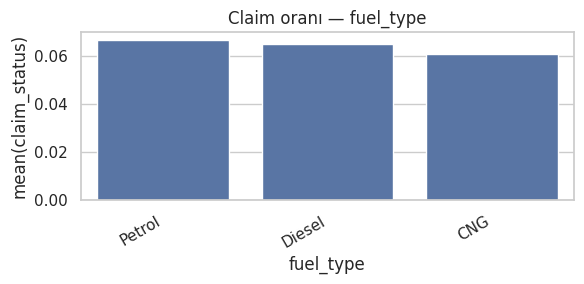

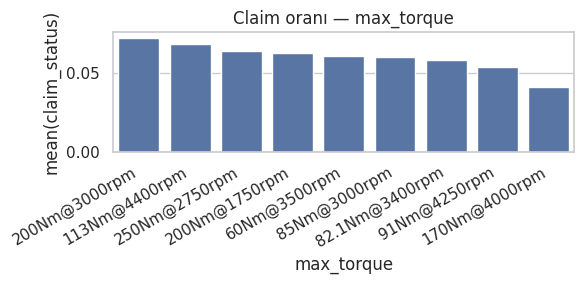

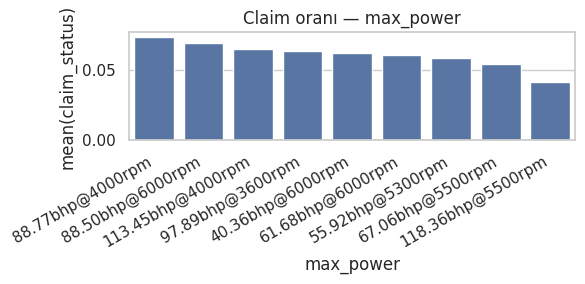

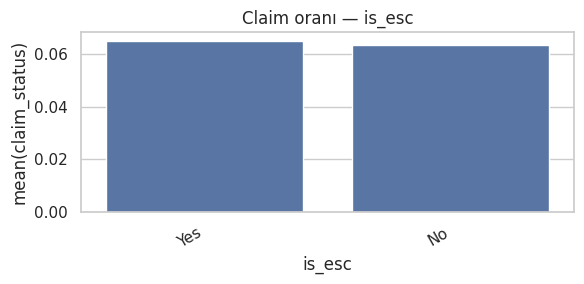

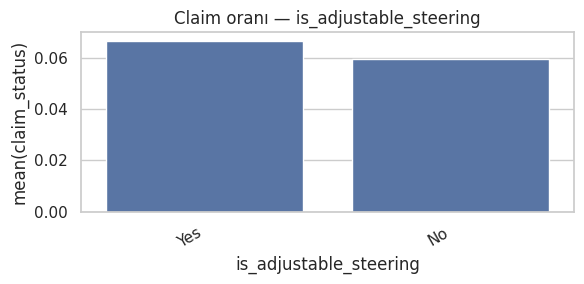

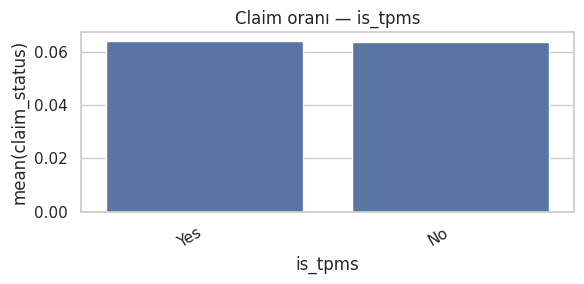

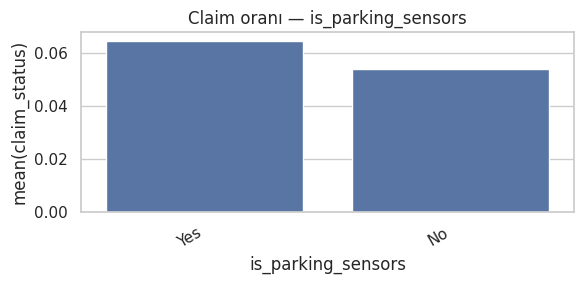

In [24]:
small_cats = [c for c in cat_cols if df[c].nunique(dropna=True) <= 10]
chi2_table = []
for col in small_cats[:8]:
    rate = df.groupby(col)[TARGET].mean().sort_values(ascending=False)
    plt.figure(figsize=(6, 3))
    sns.barplot(x=rate.index, y=rate.values)
    plt.title(f"Claim oranı — {col}")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("mean(claim_status)")
    plt.tight_layout()
    plt.show()

    ct = pd.crosstab(df[col], df[TARGET])
    if ct.shape[0] >= 2 and ct.shape[1] >= 2:
        chi2, p, dof, _ = chi2_contingency(ct)
        chi2_table.append({"feature": col, "chi2": chi2, "dof": dof, "p_value": p})

---

#### P-Değerini Doğru Anlamamız Lazım

*   **Null Hipotez (H₀):** İstatistiksel testin başlangıç noktası her zaman "sanık aksi kanıtlanana kadar masum"dur. Bizim durumumuzda bu **"İncelediğimiz özellik (örn: `is_esc`) ile `claim_status` arasında hiçbir ilişki yoktur; tamamen bağımsızdırlar"** anlamına gelir. Bu, çürütmeye çalıştığımız varsayımdır.
*   **Kanıtlar - Verilerimiz:** Bar grafiklerinde gördüğümüz farklar ve bu farkların dayandığı sayılar bizim kanıtlarımızdır.
*   **P-Değeri - "Kanıtın Gücü":** P-değeri "sanığın masum olduğu" (yani H₀'ın doğru olduğu) bir senaryoyu varsaydığımızda, elimizdeki kanıtların **en az bu kadar güçlü (veya daha ekstrem)** olmasını sırf şans eseri görme olasılığımızdır.

Yani p-değeri bize şunu söyler: **"Eğer bu özellik ile talep arasında gerçekte hiçbir bağlantı olmasaydı, sırf rastlantısal şansla, verilerde gördüğümüz kadar büyük bir farkı görme ihtimalimiz ne olurdu?"**

*   **Düşük P-Değeri (örn: 0.001):** "Eğer bu ikisi arasında ilişki olmasaydı, bu kadar güçlü bir kanıtı şans eseri görme ihtimalimiz 1000'de 1 olurdu. Bu çok düşük bir ihtimal. O halde başlangıçtaki 'ilişki yoktur' varsayımı muhtemelen yanlıştır." -> **Hipotezi reddederiz.**
*   **Yüksek P-Değeri (örn: 0.80):** "Eğer bu ikisi arasında ilişki olmasaydı bile, bu kadar küçük bir farkı şans eseri görme ihtimalimiz %80 olurdu. Bu çok sıradan bir durum. 'İlişki yoktur' varsayımını çürütecek güçlü bir kanıtım yok." -> **Hipotezi reddedemeyiz.**

Genellikle **0.05 (%5)** bir eşik olarak kullanılır. Eğer p-değeri bu eşikten küçükse, sonucu "istatistiksel olarak anlamlı" kabul ederiz.

In [25]:
pd.DataFrame(chi2_table).sort_values("p_value").reset_index(drop=True)

,feature,chi2,dof,p_value
0,is_adjustable_steering,11.231525,1,0.000804
1,max_power,19.388301,8,0.012915
2,max_torque,19.388301,8,0.012915
3,segment,12.603887,5,0.027387
4,is_parking_sensors,3.980621,1,0.046027
5,fuel_type,5.759623,2,0.056145
6,is_esc,0.499475,1,0.479731
7,is_tpms,0.022611,1,0.880473


#### **Chi2 Tablosu**

Bu yeni anlayışla tabloyu inceleyelim:

| feature | chi2 | dof | p_value | Yorum (Bu p-değeri ne anlama geliyor?) |
| :--- | :--- | :-- | :--- | :--- |
| **is_adjustable_steering** | 11.23 | 1 | **0.000804** | **ÇOK GÜÇLÜ SİNYAL:** Gördüğümüz farkın şans eseri olma olasılığı<br>sadece %0.08'dir. Bu çok düşük bir ihtimal olduğu için, özellik ile talep<br>arasında istatistiksel olarak anlamlı bir ilişki vardır. |
| **max_power** | 19.39 | 8 | **0.012915** | **GÜÇLÜ SİNYAL:** Gözlemlediğimiz bu farkın şans eseri olma<br>olasılığı sadece %1.3'tür. Bu da 0.05 eşiğinin oldukça altında olduğundan,<br>ilişki istatistiksel olarak anlamlıdır. |
| **max_torque** | 19.39 | 8 | **0.012915** | **GÜÇLÜ SİNYAL:** Motor gücüyle aynı şekilde, motor torku da<br>talep oranıyla istatistiksel olarak anlamlı bir ilişkiye sahiptir. |
| **segment** | 12.60 | 5 | **0.027387** | **ORTA GÜÇLÜ SİNYAL:** Bu farkı şans eseri görme ihtimalimiz %2.7'dir.<br>Bu da anlamlı bir ilişki olduğunu gösterir. |
| **is_parking_sensors** | 3.98 | 1 | **0.046027** | **ZAYIF AMA ANLAMLI SİNYAL:** Şans eseri görme ihtimali %4.6'dır.<br>0.05 eşiğine yakın olsa da, istatistiksel olarak anlamlı kabul edilir. |
| **fuel_type** | 5.76 | 2 | 0.056145 | **SİNYAL YOK (GÜRÜLTÜ):** p-değeri 0.05 eşiğinin **üzerindedir**.<br>Gördüğümüz farkların şans eseri olma olasılığı %5.6'dır.<br>Anlamlı bir ilişki olduğuna dair yeterli kanıt yoktur. |
| **is_esc** | 0.50 | 1 | 0.479731 | **SİNYAL YOK (GÜRÜLTÜ):** Gördüğümüz farkların şans eseri olma<br>olasılığı %48'dir. İlişki olduğuna dair istatistiksel kanıt yoktur. |
| **is_tpms** | 0.02 | 1 | 0.880473 | **SİNYAL YOK (GÜRÜLTÜ):** Gördüğümüz farkın tamamen rastlantısal<br>olma ihtimali %88'dir. Bu özellik kesinlikle bir gürültü kaynağıdır. |

## 7) Sayısal × Hedef — Violin ve Mann–Whitney U

### **Sayısal Özellikler vs. Hedef- Keman Grafikleri ve Mann-Whitney U Testi**

Buradaki temel sorumuz: "Talepte bulunan (`claim_status = 1`) ve bulunmayan (`claim_status = 0`) grupların sayısal özelliklerinin **dağılımları** birbirinden farklı mı?" Eğer bir özelliğin dağılımı bu iki grup arasında belirgin bir şekilde farklıysa, o özellik güçlü bir sinyal taşıyor demektir.

#### Görsel Analiz - Violin Plots

Violin grafiği bir özelliğin dağılımını anlamak için son derece zengin bir görselleştirme aracıdır. Onu bir **kutu grafiği (box plot)** ile bir **yoğunluk grafiğinin (density plot)** birleşimi gibi düşünebilirsiniz.

*   **Nasıl Okunur?**
    *   **Genişlik:** Grafiğin geniş olduğu yerler, verinin o değer aralığında **yoğunlaştığını** gösterir.
    *   **İçindeki Kutu:** Standart bir kutu grafiğidir; ortadaki çizgi **medyanı** temsil eder.
    *   **Karşılaştırma:** Bizim için en önemli olan, `0` ve `1` etiketli iki kemanın **şekillerinin ve konumlarının** birbirinden farklı olup olmadığıdır.

**Grafiklerin Yorumu:**

*   **`subscription_length` ~ `claim_status`:**
    *   **Gözlem:** İki kemanın şekli birbirinden oldukça **farklı**. `1` (talep var) grubunun kemanı, `0` grubuna göre alt ve üst uçlarda daha dar, orta kısımlarda ise biraz daha geniştir.
    *   **Yorum:** Abonelik süresinin talep durumu ile güçlü bir ilişkisi olduğunu gösteren **çok güçlü bir görsel sinyaldir**.

*   **`vehicle_age` ~ `claim_status`:**
    *   **Gözlem:** Her iki grup da yeni araçlarda yoğunlaşmış. Ancak `1` (talep var) grubunun kemanı, `0` grubuna göre medyan olarak hafifçe **sağa kaymış** gibi duruyor.
    *   **Yorum:** Taleplerin çok yeni araçlardan ziyade 1-2 yaşındaki araçlarda biraz daha sık olabileceğini ima eden **bir sinyaldir**.

*   **`customer_age` ~ `claim_status`:**
    *   **Gözlem:** İki kemanın şekli ve medyanlarının konumu birbirine **çok benziyor**.
    *   **Yorum:** Müşteri yaşının dağılımı, talepte bulunan ve bulunmayanlar için neredeyse aynı. Muhtemelen **zayıf bir sinyal veya gürültüdür**.

*   **`airbags`, `turning_radius`, `length`, `width`:**
    *   **Gözlem:** Bu özelliklerin tamamında, `0` ve `1` gruplarının keman grafikleri neredeyse **birbirinin kopyası** gibi duruyor.
    *   **Yorum:** Bu özelliklerin dağılımları talep durumuna göre değişmiyor. Bunlar muhtemelen **gürültüdür** ve modele bir faydası olmayacaktır.

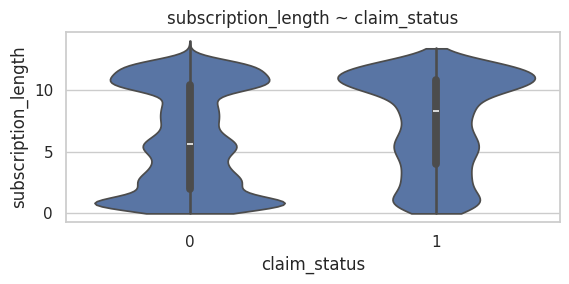

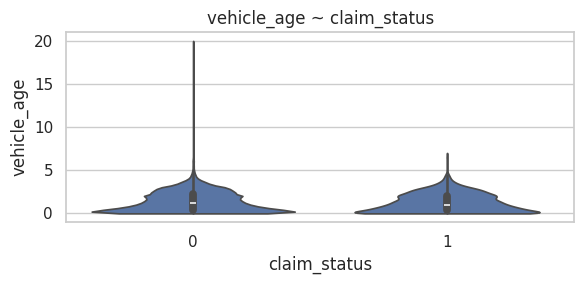

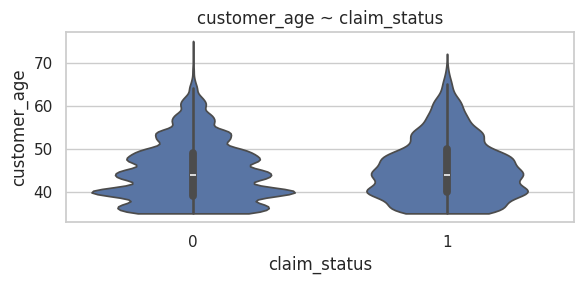

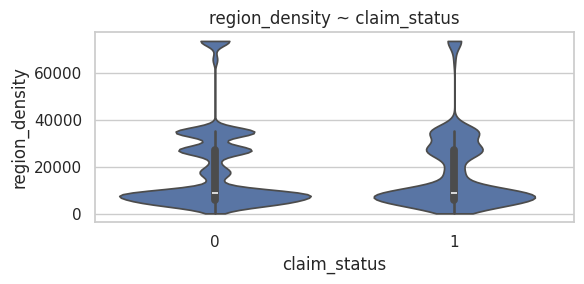

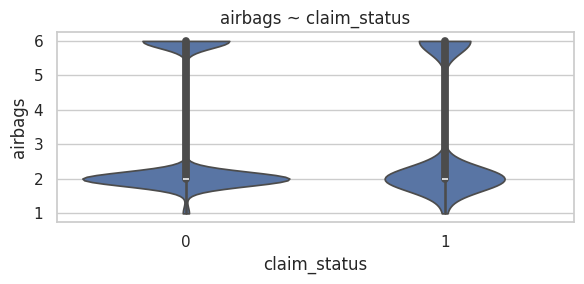

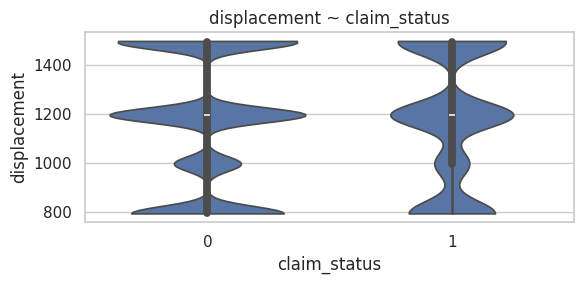

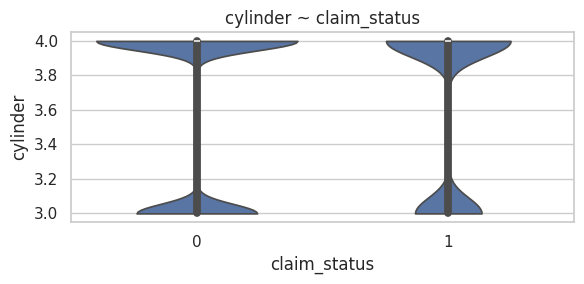

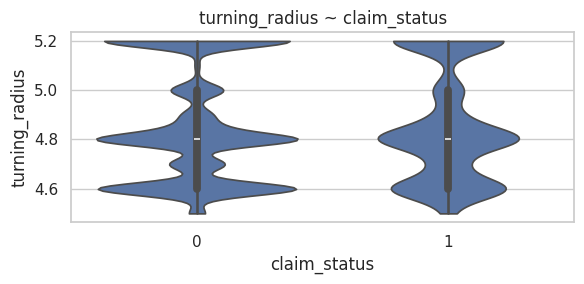

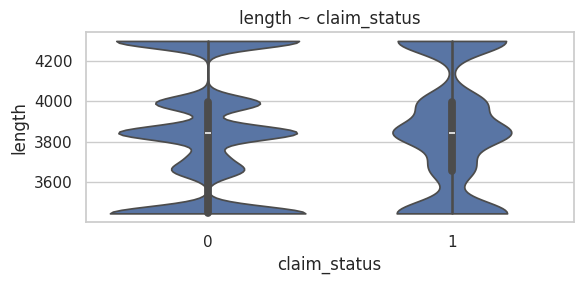

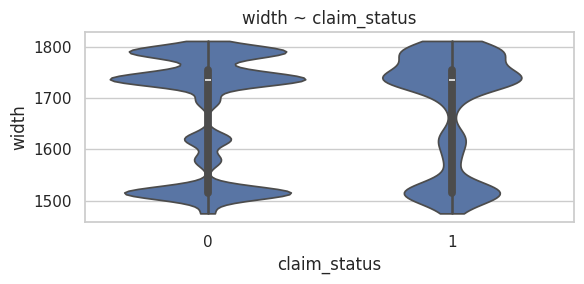

In [26]:
MWU_results = []
for col in num_cols[:10]:
    pairs = df[[col, TARGET]].dropna()
    if pairs[TARGET].nunique() == 2 and pairs[col].nunique() > 1:
        plt.figure(figsize=(6, 3))
        sns.violinplot(data=pairs, x=TARGET, y=col, cut=0)
        plt.title(f"{col} ~ {TARGET}")
        plt.tight_layout()
        plt.show()

        g0 = pairs.loc[pairs[TARGET] == 0, col]
        g1 = pairs.loc[pairs[TARGET] == 1, col]

        if len(g0) > 0 and len(g1) > 0:
            stat, p = mannwhitneyu(g0, g1, alternative="two-sided")
            MWU_results.append({"feature": col, "U": float(stat), "p_value": float(p)})

In [27]:
pd.DataFrame(MWU_results).sort_values("p_value").reset_index(drop=True)

,feature,U,p_value
0,subscription_length,84083110.5,1.013705e-77
1,vehicle_age,109567607.0,1.099771e-11
2,customer_age,97664014.5,3.204404e-07
3,cylinder,100048918.0,1.147258e-03
4,region_density,105322860.0,1.034603e-02
5,displacement,100942846.0,5.905131e-02
6,width,100964900.0,6.377655e-02
7,length,101050014.0,7.772428e-02
8,turning_radius,101802738.0,3.187275e-01
9,airbags,102192890.0,4.681584e-01


### Mann-Whitney U Testi

Görsel analiz bize hangi özelliklerin hedefle ilişkili olabileceğine dair bir hipotez verir. İstatistiksel testler ise bu hipotezi kanıtlamamızı veya çürüterek sinyali gürültüden ayırmamızı sağlar.

#### **Neden T-Testi Yerine Mann-Whitney U?**

*   **Yaygın Bir Yanılgı:** T-testi gibi parametrik testlerin, analize dahil edilen **verinin kendisinin** Normal Dağılıma (çan eğrisi) sahip olmasını gerektirdiği yaygın bir yanılgıdır. Aslında bu, özellikle küçük örneklemlerde daha çok önem kazanan basitleştirilmiş bir açıklamadır.

*   **Central Limit Theorem:** İstatistiksel olarak asıl önemli olan verinin kendisi değil, test istatistiğinin (örneğin, iki grup ortalaması arasındaki farkın) **örneklem dağılımının** normal olmasıdır. **Central Limit Theorem** bize der ki, örneklem boyutumuz yeterince büyük olduğunda (genellikle n > 50 gibi pratik bir kural kullanılır), verinin orijinal dağılımı ne kadar çarpık olursa olsun, örneklem ortalamalarının dağılımı normale yakınsar. Veri setimiz on binlerce satırdan oluştuğu için oldukça büyüktür, bu nedenle `t-testi` kullanmak aslında istatistiksel olarak **geçerli bir seçenek olabilirdi.**

*   **Peki Neden Yine de Mann-Whitney U?**
    1.  **Parametrik Değil:** Mann-Whitney U testi **non-parametrik** bir testtir. Yani  dağılımla ilgili **hiçbir varsayımda bulunmaz**. Bu onu Merkezi Limit Teoremi'nin etkilerine güvenmek zorunda kalmadığımız doğası gereği daha güvenli bir seçenek haline getirir.
    2.  **Doğru Soruyu Sorar:** T-testi **ortalamaları** karşılaştırırken Mann-Whitney U testi **medyanları** (veya daha genel olarak sıralamaları) karşılaştırır.

Özetle veri setimizde t-testi yanlış olmasa da, Mann-Whitney U testi hem daha az varsayıma dayandığı hem de çarpık verilerimiz için daha uygun bir merkezi eğilim ölçüsünü (medyan) karşılaştırdığı için **daha ideal bir tercihtir.**

*   **Hipotez (H₀):** Testin null hipotezi şudur: "`0` (talep yok) ve `1` (talep var) gruplarından rastgele seçilen bir değerin bir diğerinden büyük olma olasılığı eşittir." Yani **iki grubun dağılımları arasında anlamlı bir fark yoktur.**

*   **P-Değeri (p_value):** "Eğer iki grubun dağılımları gerçekte aynı olsaydı, verilerimizde gördüğümüz kadar büyük bir farkı sırf şans eseri görme ihtimalimiz nedir?" sorusunun cevabıdır.

**Test Sonuçları Tablosunun Yorumu:**

| feature | U | p_value | Yorum (Bu p-değeri ne anlama geliyor?) |
| :--- | :--- | :--- | :--- |
| **subscription_length** | 8.41e+07 | **1.01e-77** | **EZİCİ DERECEDE GÜÇLÜ SİNYAL:** p-değeri neredeyse sıfırdır.<br>Veri setimizdeki **en güçlü sayısal tahmin edicidir**. |
| **vehicle_age** | 1.10e+08 | **1.10e-11** | **ÇOK GÜÇLÜ SİNYAL:** p-değeri astronomik derecede küçüktür.<br>Görseldeki hafif farkın istatistiksel olarak çok anlamlı olduğunu kanıtlar. |
| **customer_age** | 9.77e+07 | **3.20e-07** | **GÜÇLÜ SİNYAL:** Görsel olarak fark etmek zor olsa da, istatistiksel test<br>iki grubun yaş dağılımları arasında anlamlı bir fark olduğunu söyler. |
| **cylinder** | 1.00e+08 | **0.001147** | **ORTA GÜÇLÜ SİNYAL:** p-değeri 0.05'in oldukça altındadır.<br>Silindir sayısının talep durumu ile bir ilişkisi vardır. |
| **region_density** | 1.05e+08 | **0.010346** | **ORTA GÜÇLÜ SİNYAL:** Bölge yoğunluğunun dağılımı, talep olan ve<br>olmayan gruplar için anlamlı şekilde farklıdır. |
| **displacement** | 1.01e+08 | 0.059051 | **SİNYAL YOK (GÜRÜLTÜ):** p-değeri 0.05 eşiğinin **üzerindedir**.<br>Gördüğümüz farklar muhtemelen tesadüfidir. |
| **width** | 1.01e+08 | 0.063777 | **SİNYAL YOK (GÜRÜLTÜ):** p-değeri 0.05'in üzerindedir.<br>Anlamlı bir ilişki olduğuna dair yeterli kanıt yoktur. |
| **length** | 1.01e+08 | 0.077724 | **SİNYAL YOK (GÜRÜLTÜ):** p-değeri 0.05'in üzerindedir. |
| **turning_radius** | 1.02e+08 | 0.318728 | **SİNYAL YOK (GÜRÜLTÜ):** p-değeri çok yüksektir.<br>Gördüğümüz farkların şans eseri olma olasılığı %32'dir. |
| **airbags** | 1.02e+08 | 0.468158 | **SİNYAL YOK (GÜRÜLTÜ):** p-değeri çok yüksektir.<br>Hava yastığı sayısının talep durumuyla bir ilişkisi yoktur. |

#### **Genel Çıkarım**

`subscription_length`, `vehicle_age` ve `customer_age` gibi özelliklerin modelimiz için hayati önem taşıdığını, `airbags` ve `turning_radius` gibi özelliklerin ise muhtemelen modelden çıkarılması gerektiğini istatistiksel olarak kanıtlamış olduk. Modelimizi daha basit, daha hızlı ve daha doğru hale getirecek olan **özellik seçimi (feature selection)** için sağlam bir temel oluşturur.

## 8) Sayısal Korelasyon Isı Haritası ve VIF


Şimdiye kadar özellikleri tek tek veya hedef değişkenle olan ilişkileri açısından inceledik. Şimdi ise "Hangi özellikler birbiriyle aynı hikayeyi anlatıyor?" sorusunu soruyoruz.

**Problem:** Bir makine öğrenmesi modelini, aynı bilgiyi farklı kelimelerle anlatan bir grup danışmanla beslemeye benzer. Model, hangi danışmanın (özelliğin) gerçekten önemli olduğunu anlamakta zorlanır çünkü verdikleri bilgiler birbirinin tekrarıdır. Bu duruma **Çoklu Doğrusal Bağlantı (Multicollinearity)** denir ve özellikle doğrusal modellerin (Lineer Regresyon, Lojistik Regresyon vb.) katsayılarını kararsız hale getirerek modelin yorumlanabilirliğini bozar.

#### Korelasyon Isı Haritası (Correlation Heatmap)

Bu sorunu tespit etmenin ilk adımı, tüm sayısal özellikler arasındaki ikili ilişkileri gösteren bir korelasyon ısı haritası çizmektir.

**Nasıl Okunur?**

*   **Koyu Kırmızı (+1.0):** İki özellik arasında **güçlü pozitif korelasyon** var demektir. Biri artarken diğeri de artar. (Örn: aracın motor hacmi ve beygir gücü).
*   **Koyu Mavi (-1.0):** İki özellik arasında **güçlü negatif korelasyon** var demektir. Biri artarken diğeri azalır.
*   **Beyaz/Açık Renkler (0.0):** İki özellik arasında **ilişki yok** demektir.

**Bizim Grafiğimiz Ne Söylüyor?**

*   Grafiğimizde, özellikle orta ve sağ alt bölgelerde **büyük, koyu kırmızı bir kare** olduğunu hemen fark ediyoruz. Bu, ciddi bir çoklu doğrusal bağlantı sorununun bariz bir işaretidir.
*   **Örnek Gruplar:**
    *   `displacement` (motor hacmi), `cylinder` (silindir sayısı), `length` (uzunluk), `width` (genişlik), `gross_weight` (ağırlık) ve `power_bhp` (beygir gücü) gibi özellikler birbiriyle çok yüksek pozitif korelasyona sahiptir.
    *   Bu mantıklıdır: Daha büyük motor hacmine sahip bir araç genellikle daha fazla silindire, daha fazla beygir gücüne, daha büyük boyutlara ve daha fazla ağırlığa sahip olur. Bu özelliklerin hepsi temelde aynı şeyi ölçüyor: **"Aracın büyüklüğü ve gücü"**.

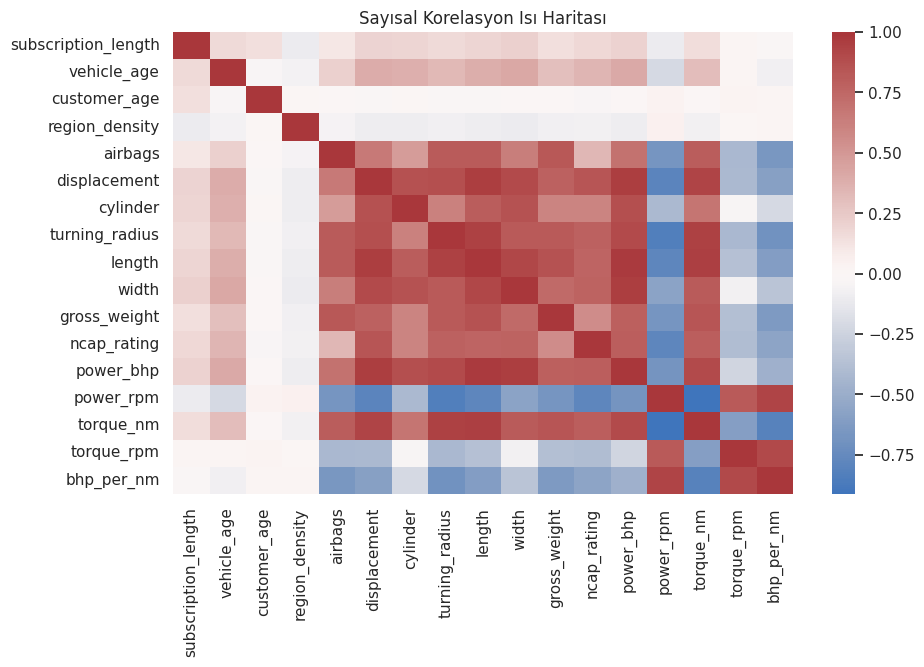

In [28]:
if len(num_cols) >= 2:
    plt.figure(figsize=(10, 6))
    corr = df[num_cols].corr(numeric_only=True)
    sns.heatmap(corr, cmap="vlag", center=0)
    plt.title("Sayısal Korelasyon Isı Haritası")
    plt.show()

In [37]:
X_vif = df[num_cols].copy()
if not X_vif.empty and X_vif.shape[1] >= 2:
    for c in X_vif.columns:
        X_vif[c] = X_vif[c].fillna(X_vif[c].median())
    X_vif = (X_vif - X_vif.mean()) / X_vif.std(ddof=0)
    cond = np.linalg.cond(np.nan_to_num(X_vif.values))
    if np.isfinite(cond) and cond < 1e18:
        vif_rows = [
            {"feature": c, "VIF": variance_inflation_factor(X_vif.values, i)}
            for i, c in enumerate(X_vif.columns)
        ]
        print(
            pd.DataFrame(vif_rows)
            .sort_values("VIF", ascending=False)
            .reset_index(drop=True)
        )

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



                feature         VIF
0               airbags         inf
1             power_rpm         inf
2        turning_radius         inf
3              cylinder         inf
4          displacement         inf
5             power_bhp         inf
6           ncap_rating         inf
7          gross_weight         inf
8                 width         inf
9            torque_rpm         inf
10            torque_nm         inf
11           bhp_per_nm         inf
12               length  252.476911
13          vehicle_age    1.277593
14  subscription_length    1.098598
15         customer_age    1.037400
16       region_density    1.018573


### Variance Inflation Factor (VIF) Nedir?

**Variance Inflation Factor (VIF)**, bir ML modelindeki bir sayısal özelliğin, diğer sayısal özelliklerle ne kadar güçlü bir şekilde ilişkili olduğunu ölçen bir metriktir. Bu durum, yani özelliklerin birbirinden bağımsız olmaması, **Çoklu Doğrusal Bağlantı (Multicollinearity)** olarak adlandırılır.

**Sezgisel Analoji:**
Bir dedektif ekibiniz olduğunu düşünün. Bir olayı çözmek için 10 dedektif görevlendirdiniz. Ancak bu dedektiflerden 8'i, sürekli olarak birbirlerinin raporlarını kopyalayıp aynı bilgiyi farklı kelimelerle size sunuyor. Sonuç olarak, elinizde aslında 10 farklı bakış açısı yerine belki de sadece 3 farklı bakış açısı olur. Bu durum, hangi dedektifin gerçekten değerli bir ipucu bulduğunu anlamanızı zorlaştırır.

İşte VIF, bu "birbirinin raporunu kopyalayan" dedektifleri (özellikleri) tespit etmemize yarar.

**VIF Nasıl Hesaplanır?**
Her bir özellik için VIF değeri şu adımlarla hesaplanır:
1.  Bir özellik (örneğin `power_bhp`) seçilir.
2.  Bu özellik diğer **tüm sayısal özellikler** kullanılarak bir lineer regresyon modeli ile tahmin edilmeye çalışılır.
3.  Bu modelin ne kadar başarılı olduğunu gösteren `R²` (R-kare) değeri hesaplanır. `R²=0.95` demek, `power_bhp`'nin %95'inin diğer özellikler tarafından açıklanabildiği anlamına gelir.
4.  Son olarak VIF şu formülle bulunur: **`VIF = 1 / (1 - R²)`**

**VIF Değerleri Nasıl Yorumlanır?**
*   **VIF = 1:** Mükemmel durum. Özellik, diğer özelliklerle hiç ilişkili değildir. (`R²=0`)
*   **1 < VIF < 5:** Düşük ila orta düzeyde korelasyon. Genellikle endişe verici değildir ve kabul edilebilir.
*   **VIF > 5:** Potansiyel olarak sorunlu, yüksek korelasyon. Dikkatle incelenmelidir.
*   **VIF > 10:** Ciddi çoklu doğrusal bağlantı sorunu. Müdahale (özellik elemesi gibi) genellikle gereklidir.
*   **VIF = `inf` (Sonsuz):** Mükemmel çoklu doğrusal bağlantı. Bu bize bir özelliğin diğer özelliklerin %100 hatasız bir lineer kombinasyonu olduğu anlamına gelir (`R²=1`). Bu veri setinde aynı bilginin tekrarlandığının kesin bir kanıtıdır.

---

#### VIF Tablosunun Yorumlanması

| feature | VIF | Yorum |
| :--- | :--- | :--- |
| **airbags, power_rpm, ..., bhp_per_nm** | `inf` | **MÜKEMMEL ÇOKLU DOĞRUSAL BAĞLANTI:**<br>Bu özelliklerin her biri, diğer sayısal özelliklerin bir kombinasyonu ile<br>%100 hatasız bir şekilde tahmin edilebilir. Aynı bilginin<br>farklı sütunlarda tekrarlandığı anlamına gelir ve bu özellikler<br>aynı anda bir modelde bulunamaz. |
| **length** | 252.48 | **AŞIRI YÜKSEK:** Sonsuz olmasa da, bu değer kabul edilemez<br>derecede yüksektir. `length` özelliği, diğer özelliklerle<br>çok güçlü bir şekilde ilişkilidir ve gereksiz bilgi tekrarı yaratır. |
| **vehicle_age** | 1.28 | **MÜKEMMEL:** VIF değeri 1'e çok yakındır. `vehicle_age` özelliğinin<br>diğer sayısal özelliklerden büyük ölçüde bağımsız olduğunu ve<br>modele benzersiz bir bilgi sağladığını gösterir. |
| **subscription_length** | 1.10 | **MÜKEMMEL:** `vehicle_age` gibi, bu özellik de modele<br>tekrarlanmayan, değerli bir bilgi sunar. |
| **customer_age** | 1.04 | **MÜKEMMEL:** Diğer özelliklerle neredeyse hiç ilişkisi yoktur. |
| **region_density** | 1.02 | **MÜKEMMEL:** Diğer özelliklerden tamamen bağımsızdır. |

**Sonuç:** Bu analiz modelimizi eğitmeden önce `airbags`, `power_rpm`, `length` gibi VIF değeri sonsuz veya çok yüksek olan özellik gruplarından eleme yapmamız gerektiğini açıkça göstermektedir.

#### **Peki Şimdi Ne Yapacağız? Çözüm Stratejileri**

Bu sorunu çözmek için birkaç yaygın yöntem vardır:

1.  **Özelliklerden Birini Çıkarmak (En Yaygın Yöntem):**
    *   Yüksek VIF değerine sahip özellik grubundan (örn: `displacement`, `power_bhp`, `gross_weight`) **sadece birini** tutarız ve diğerlerini veri setinden çıkarırız.
    *   Hangisini tutacağımıza karar verirken genellikle hedef değişkenle en güçlü ilişkiye sahip olanı veya iş bilgisi açısından en anlamlı olanı seçeriz.

2.  **Özellikleri Birleştirmek:**
    *   Yüksek korelasyonlu özellikleri birleştirerek yeni bir özellik yaratabiliriz. Örneğin, `power_bhp`'yi `gross_weight`'e bölerek "ağırlık başına güç" gibi yeni bir metrik oluşturabiliriz.
    *   Daha gelişmiş bir yöntem ise **Temel Bileşenler Analizi (PCA)** gibi boyut azaltma teknikleri kullanmaktır.

3.  **Dayanıklı Modeller Kullanmak:**
    *   **Ridge Regresyon** gibi bazı modeller, çoklu doğrusal bağlantı sorununa karşı daha dayanıklıdır.

**Nihai Hedef:** Modelimize aynı bilgiyi tekrar tekrar veren özellikleri ayıklayarak, daha basit, daha hızlı çalışan, daha iyi genelleme yapan ve sonuçları daha kolay yorumlanan bir model oluşturmaktır.

## 9) Aykırı Değer Analizi — IQR ve Z-score

**Aykırı Değer Nedir?**
Bir aykırı değer veri setinin geri kalanından önemli ölçüde farklı olan bir gözlemdir. Örneğin, bir mahalledeki ev fiyatlarını incelerken, evlerin çoğu 1-2 milyon TL aralığındayken, 50 milyon TL'lik bir şato aykırı bir değerdir.

**Neden Önemlidir?**
Bu aşırı (veua ekstrem diyebiliriz) değerler özellikle ortalama ve standart sapma gibi istatistiksel ölçümlere dayanan modelleri (Lineer Regresyon, Lojistik Regresyon, K-Means vb.) ciddi şekilde yanıltabilir. Modelin, bu tek bir aşırı değere aşırı odaklanarak verinin genel trendini kaçırmasına neden olabilirler.

Aykırı değerleri tespit etmek için iki yaygın yöntem vardır:

#### 1. IQR (Interquartile Range) Yöntemi - Tekrar Edelim

Bu yöntem bir özelliğin dağılımının "orta %50'lik" kısmını temel alır ve bu nedenle **çarpık (skewed) dağılımlara karşı çok daha sağlamdır**.

*   **Nasıl Çalışır?**
    1.  **Q1 (1. Çeyreklik):** Verinin %25'inin altında kaldığı değer bulunur.
    2.  **Q3 (3. Çeyreklik):** Verinin %75'inin altında kaldığı değer bulunur.
    3.  **IQR:** `Q3 - Q1` farkı hesaplanır. Bu, verinin orta yarısının genişliğidir.
    4.  **Sınırlar (Fences):** Alt ve üst sınırlar şu şekilde belirlenir:
        *   Alt Sınır = `Q1 - 1.5 * IQR`
        *   Üst Sınır = `Q3 + 1.5 * IQR`
    5.  Bu sınırların dışında kalan herhangi bir veri noktası "aykırı değer" olarak etiketlenir.

#### Z-Skoru (Z-score) Yöntemi

Bu yöntem bir veri noktasının ortalamadan kaç standart sapma uzakta olduğunu ölçer. **Normal dağılıma yakın (simetrik) veriler için en iyi sonucu verir.**

*   **Nasıl Çalışır?**
    1.  Her bir veri noktası için Z-skoru hesaplanır: `Z = (değer - ortalama) / standart_sapma`
    2.  Genel bir kural olarak, mutlak değeri 3'ten büyük olan Z-skorları (`|Z| > 3`) aykırı değer olarak kabul edilir. Normal dağılımda verinin yaklaşık %99.7'sinin ortalamadan ±3 standart sapma içinde yer alması prensibine dayanır.
---

### En çok sorulabilecek soru: Verinin Normal Dağılım Olması Gerekir Mi?
  
  - HAYIR ama çok fazla çarpık olan bir veride istenildiği gibi çalışmayabilir, dağılıma bakıp aykırı diye işaretlenen değerleri incelemek gerekir. Yani aykırı değerleri arıyoruz bu yöntemi kullanıyoruz ama amaç nedir? Bunu düşünerek hareket etmeliyiz.
  
  - Aykırı değerler probleme göre değişiklik gösterebilir.

In [39]:
out_rows = []
for col in num_cols:
    s = df[col].dropna()
    if len(s) >= 10:
        q1, q3 = np.percentile(s, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        iqr_pct = ((s < lo) | (s > hi)).mean() * 100
        z = (s - s.mean()) / s.std(ddof=0)
        z_pct = (np.abs(z) > 3).mean() * 100
        out_rows.append(
            {"feature": col, "IQR_outlier_%": iqr_pct, "Z3_outlier_%": z_pct}
        )

pd.DataFrame(out_rows).sort_values("IQR_outlier_%", ascending=False).reset_index(
    drop=True
)

,feature,IQR_outlier_%,Z3_outlier_%
0,region_density,6.224399,5.384694
1,customer_age,0.481294,0.285022
2,vehicle_age,0.459107,0.570044
3,subscription_length,0.000000,0.000000
4,airbags,0.000000,0.000000
5,displacement,0.000000,0.000000
6,cylinder,0.000000,0.000000
7,turning_radius,0.000000,0.000000
8,length,0.000000,0.000000
9,width,0.000000,0.000000


### Analiz Sonuçları Tablosu

| feature | IQR_outlier_% | Z3_outlier_% | Yorum |
| :--- | :--- | :--- | :--- |
| **region_density** | 6.22 | 5.38 | **AYKIRI DEĞERLER VAR:**<br>Verinin yaklaşık %6'sı aykırı olarak tespit edilmiş. Bu, histogramda<br>gördüğümüz uzun kuyruklu yapıyla tutarlıdır. Çok yüksek nüfus yoğunluğuna<br>sahip az sayıda bölge, verinin genel yapısının dışında kalmaktadır. |
| **customer_age** | 0.48 | 0.29 | **AZ SAYIDA AYKIRI DEĞER VAR:**<br>Müşterilerin %0.5'inden azı aykırı olarak etiketlenmiş. Bunlar muhtemelen<br>veri setindeki çok genç veya çok yaşlı müşterilerdir. Bu kadar düşük bir oran<br>genellikle endişe verici değildir. |
| **vehicle_age** | 0.46 | 0.57 | **AZ SAYIDA AYKIRI DEĞER VAR:**<br>Müşteri yaşına benzer şekilde, çok eski birkaç araç veri setinin<br>geri kalanından ayrışmaktadır. Bu da beklenen bir durumdur. |
| **subscription_length, airbags, ...** | 0.00 | 0.00 | **AYKIRI DEĞER YOK:**<br>Bu özelliklerde aykırı değer bulunmamasının sebebi, bu özelliklerin<br>**ayrık (discrete)** veya **sınırlı sayıda değere** sahip olmasıdır. Örneğin,<br>`cylinder` sütunu sadece 3 ve 4 gibi değerler alıyorsa, bir değerin "aşırı"<br>olması imkansızdır. Veri, doğası gereği sınırlı bir aralıkta yer alır. |

#### Aykırı Değerlerle Ne Yapmalı?

Aykırı değerleri tespit ettikten sonra onlarla nasıl başa çıkacağımıza karar vermemiz gerekir:

1.  **Hiçbir Şey Yapmamak:** Eğer kullandığımız model aykırı değerlere karşı dayanıklıysa (örneğin Random Forest gibi ağaç tabanlı modeller), onları olduğu gibi bırakabiliriz.
2.  **Veriyi Dönüştürmek (Transform):** `region_density` gibi çarpık özelliklere **logaritmik dönüşüm** uygulamak, bu aşırı değerlerin etkisini azaltarak onları verinin geri kalanına yaklaştırabilir.
3.  **Değerleri Sınırlamak (Capping/Winsorizing):** Aykırı değerleri silmek yerine, onları IQR yöntemiyle belirlediğimiz alt ve üst sınırlara eşitleyebiliriz. Örneğin, üst sınırın üzerinde kalan tüm değerleri, üst sınır değerine ayarlayabiliriz. Veri kaybı olmadan aşırılıkları kontrol altına almamızı sağlar.
4.  **Silmek:** Eğer bir aykırı değerin bariz bir veri giriş hatası olduğundan eminsek (örneğin, müşteri yaşı 200), o satırı silmek en doğru seçenek olabilir. Ancak bu yöntem dikkatli kullanılmalıdır çünkü gerçek ama nadir durumları da kaybetme riski taşır.

### Unutmamalıyız ki ML işlerinde en iyi yöntem X'tir demek doğru olmaz, şartlara ve projeye göre izlenecek adımlar değişiklik gösterecektirç.